In [3]:
% matplotlib inline
from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import glob
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column, join
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection

# Personal
import hscUtils as hUtil
#import galSBP
#import coaddCutoutGalfitSimple as gSimple 

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

import emcee
import corner

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

import cPickle
from astroML.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

## Constants
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.15, 0.64
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [0.16, 0.11, 0.59, 0.88]
recHist = [0.75, 0.11, 0.24, 0.88]
SBP1 = [0.124, 0.085, 0.865, 0.33]
SBP2 = [0.124, 0.41, 0.865, 0.55]
EC1 = [0.19, 0.14, 0.65, 0.65]
EC2 = [0.19, 0.79, 0.65, 0.18]
EC3 = [0.84, 0.14, 0.157, 0.65]
REC = [0.12, 0.11, 0.87, 0.87]
COG1 = [0.143, 0.10, 0.850, 0.43]
COG2 = [0.143, 0.53, 0.850, 0.43]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
RR50_COMMON = np.arange(0.0, 9.0, 0.01)
EMPTY = (RSMA_COMMON * np.nan)

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# Color maps for different filters
from palettable.colorbrewer.sequential import Blues_9, Greens_9, Reds_9, Purples_9, Greys_9
GCMAP = Blues_9.mpl_colormap
RCMAP = Greens_9.mpl_colormap
ICMAP = Reds_9.mpl_colormap
ZCMAP = Purples_9.mpl_colormap
YCMAP = Greys_9.mpl_colormap

# 3-sigma
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

#import seaborn as sns
#sns.set(color_codes=False)

# Location of Files

In [4]:
# Location of the data
homeDir = os.getenv('HOME')
synpipeDir = os.path.join(homeDir, 'astro4/synpipe/')
sampleDir = os.path.join(synpipeDir, 'sample/cosmos_star')

# The ACS Clean sample
starCat = os.path.join(sampleDir, 'cosmos_star_i26.5_ascMatched_clean.fits')
starData = Table.read(starCat, format='fits')

# The HSC COSMOS point sources catalog
hscCat = os.path.join(sampleDir, 'cosmos_star_i26.5.fits')
hscData = Table.read(hscCat, format='fits')

In [5]:
hscClean = hscData[(np.isfinite(hscData['gmag_psf'])) & 
                   (hscData['gmag_psf'] <= 29.0) &
                   (np.isfinite(hscData['rmag_psf'])) & 
                   (hscData['rmag_psf'] <= 29.0) & 
                   (np.isfinite(hscData['imag_psf'])) & 
                   (hscData['imag_psf'] <= 29.0) & 
                   (np.isfinite(hscData['zmag_psf'])) & 
                   (hscData['zmag_psf'] <= 29.0) & 
                   (np.isfinite(hscData['ymag_psf'])) & 
                   (hscData['ymag_psf'] <= 29.0)]

/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal
/Users/song/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


In [6]:
# Outputs 
figDir = os.path.join(synpipeDir, 'figure')
outDir = os.path.join(synpipeDir, 'outputs')
inDir = os.path.join(synpipeDir, 'inputs')

In [7]:
print(len(starData))
print(len(hscClean))

14472
75802


In [8]:
print(starData.colnames)

['id_hsc', 'ra_hsc', 'dec_hsc', 'tract', 'patch', 'parent_id', 'a_g', 'a_r', 'a_i', 'a_z', 'a_y', 'gmag_psf', 'gmag_psf_err', 'rmag_psf', 'rmag_psf_err', 'imag_psf', 'imag_psf_err', 'zmag_psf', 'zmag_psf_err', 'ymag_psf', 'ymag_psf_err', 'gblendedness_abs_flux', 'rblendedness_abs_flux', 'iblendedness_abs_flux', 'zblendedness_abs_flux', 'yblendedness_abs_flux', 'gblendedness_flags', 'rblendedness_flags', 'iblendedness_flags', 'zblendedness_flags', 'yblendedness_flags', 'gcountinputs', 'rcountinputs', 'icountinputs', 'zcountinputs', 'ycountinputs', 'gclassification_extendedness', 'rclassification_extendedness', 'iclassification_extendedness', 'zclassification_extendedness', 'yclassification_extendedness', 'gflux_psf_flags', 'rflux_psf_flags', 'iflux_psf_flags', 'zflux_psf_flags', 'yflux_psf_flags', 'gflags_pixel_edge', 'rflags_pixel_edge', 'iflags_pixel_edge', 'zflags_pixel_edge', 'yflags_pixel_edge', 'gflags_pixel_interpolated_any', 'rflags_pixel_interpolated_any', 'iflags_pixel_interpo

# Basic Properties of the Stars

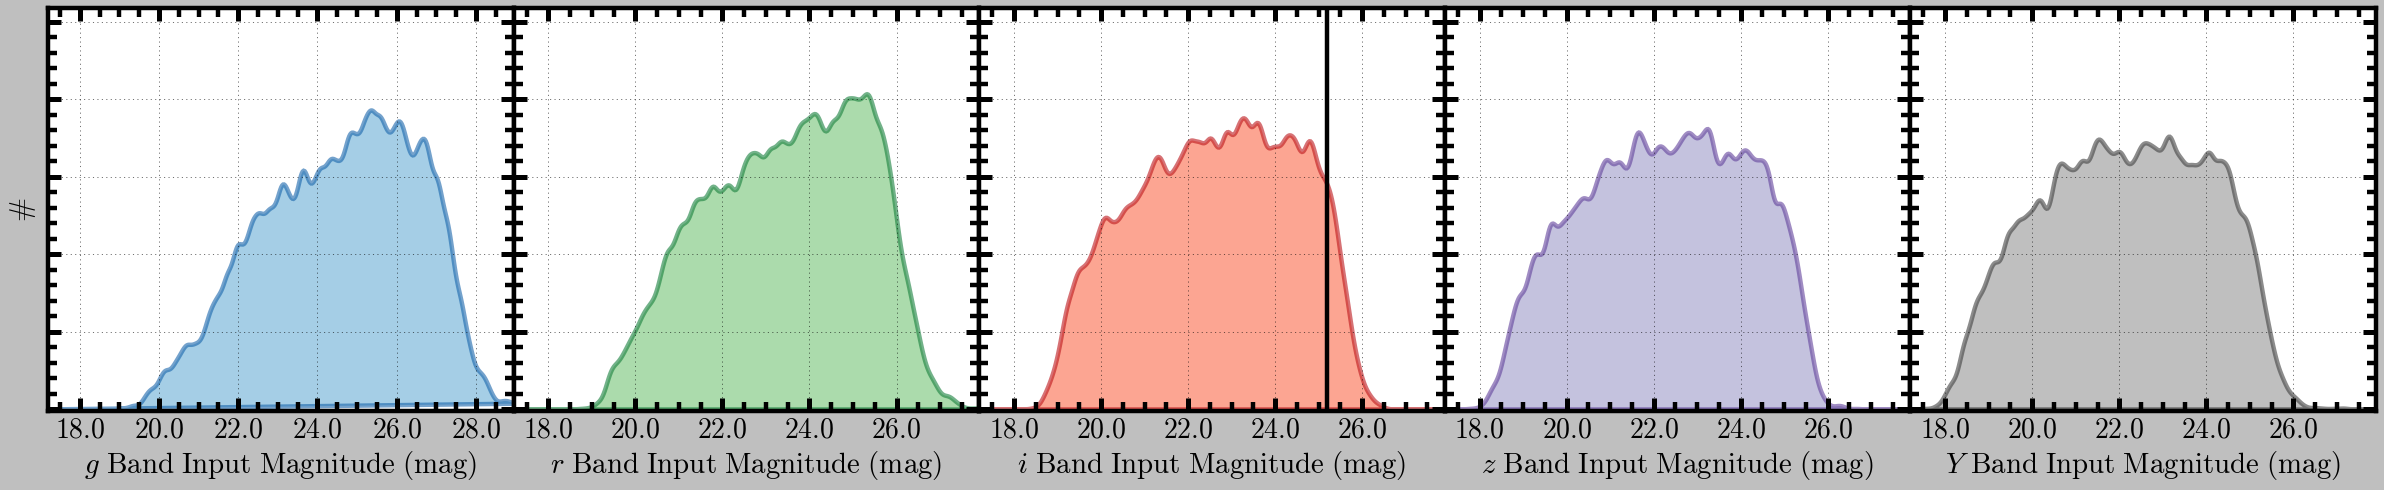

In [19]:
xtickFormat, ytickFormat = r'$\mathbf{%4.1f}$', r'$\mathbf{%4.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(30,6))
fig.subplots_adjust(left=0.02, right=0.99, bottom=0.15, top=0.99, 
                    hspace=0.0, wspace=0.0)

# --------------------------------------------------------------------------------------- #
## Ax1
ax1 = fig.add_subplot(151)
ax1.grid()
ax1 = songPlotSetup(ax1, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

## X, Y limits
xmin, xmax = 17.2, 28.95
ymin, ymax = -0.001, 0.259

# Good seeing
xx = starData['gmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax1.fill(xPlot[:, None], np.exp(log_dens), facecolor=GCMAP(0.5), edgecolor=GCMAP(0.8), 
         alpha=0.6, linewidth=4.0, label=r'$\mathrm{Good\ Seein}$')

ax1.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$g\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ylabel = r'$\#$'
ax1.set_xlabel(xlabel, size=26)
ax1.set_ylabel(ylabel, size=26)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
"""
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.04, 0.72), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(GCMAP(0.6))
"""
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2
ax2 = fig.add_subplot(152)
ax2.grid()
ax2 = songPlotSetup(ax2, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['rmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=RCMAP(0.5), edgecolor=RCMAP(0.8), 
         alpha=0.6, linewidth=4.0)

ax2.set_ylim(ax1.get_ylim())
ax2.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$r\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax2.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax2.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax3
ax3 = fig.add_subplot(153)
ax3.grid()
ax3 = songPlotSetup(ax3, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['imag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax3.fill(xPlot[:, None], np.exp(log_dens), facecolor=ICMAP(0.5), edgecolor=ICMAP(0.8), 
         alpha=0.6, linewidth=4.0)

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())

ax3.axvline(25.2, linewidth=4.0, c='k')

xlabel = r'$i\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax3.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax3.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax4
ax4 = fig.add_subplot(154)
ax4.grid()
ax4 = songPlotSetup(ax4, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['zmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax4.fill(xPlot[:, None], np.exp(log_dens), facecolor=ZCMAP(0.5), edgecolor=ZCMAP(0.8), 
         alpha=0.6, linewidth=4.0)

ax4.set_ylim(ax1.get_ylim())
ax4.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$z\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax4.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax4.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax5
ax5 = fig.add_subplot(155)
ax5.grid()
ax5 = songPlotSetup(ax5, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['ymag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax5.fill(xPlot[:, None], np.exp(log_dens), facecolor=YCMAP(0.5), edgecolor=YCMAP(0.8), 
         alpha=0.6, linewidth=4.0)

ax5.set_ylim(ax1.get_ylim())
ax5.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$Y\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax5.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax5.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
fig.savefig(os.path.join(figDir, 'cosmos_star_hist_1.pdf'), 
            format='pdf', dpi=90)

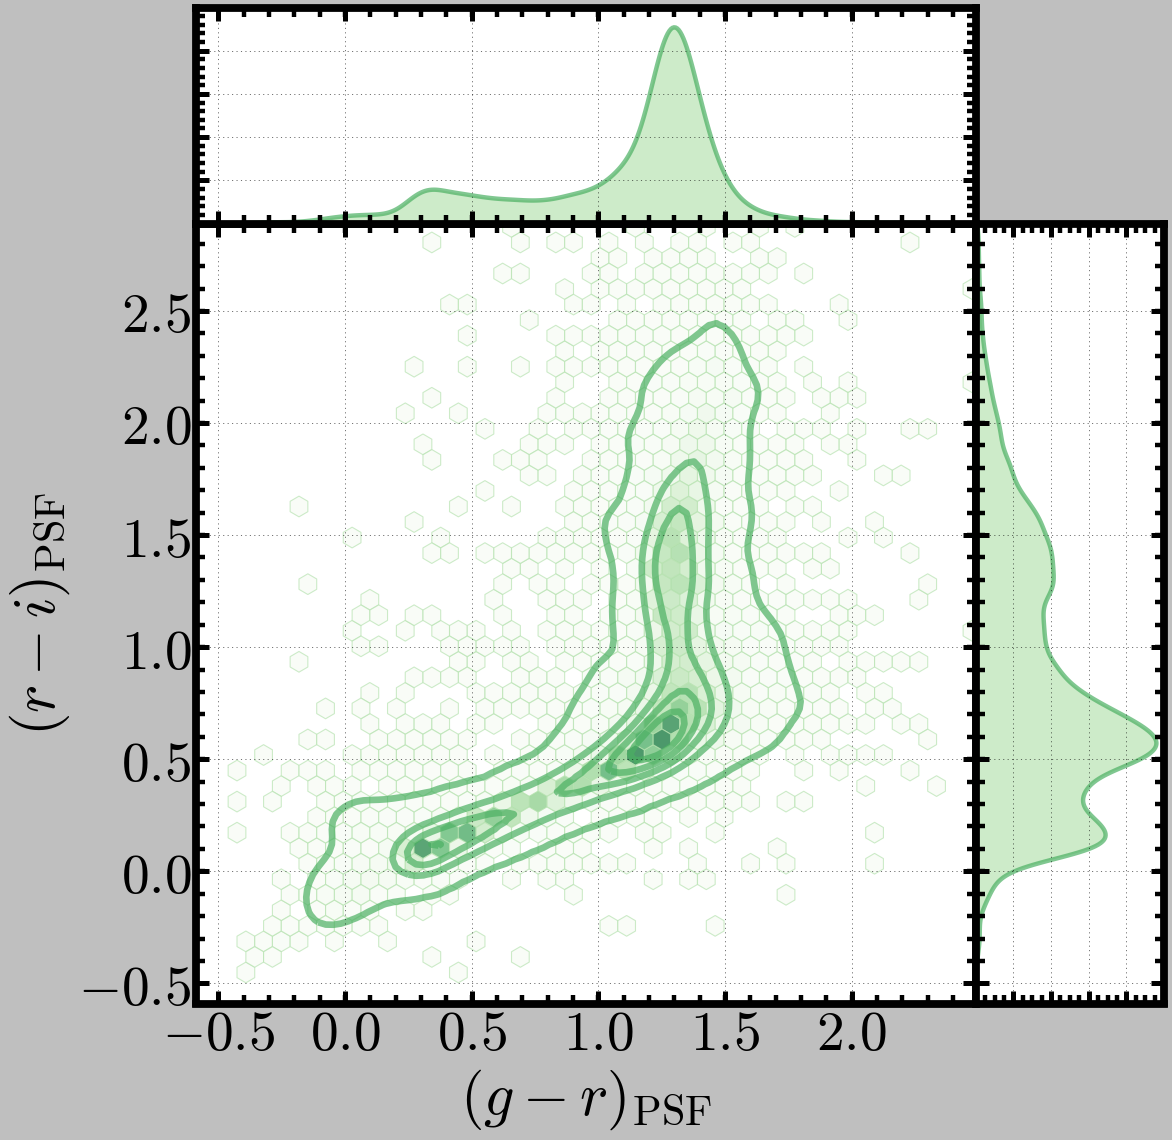

In [25]:
# --------------------------------------------------------------------------------------- #
## Prepare the data

xmin, xmax = -0.59, 2.49
ymin, ymax = -0.59, 2.89

xx = starData['gmag_psf'] - starData['rmag_psf']
yy = starData['rmag_psf'] - starData['imag_psf']
xTemp, yTemp = copy.deepcopy(xx), copy.deepcopy(yy)
xx = xx[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]
yy = yy[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]

xlabel = r'$(g-r)_{\mathrm{PSF}}} \mathrm{(mag)}$'
ylabel = r'$(r-i)_{\mathrm{PSF}}} \mathrm{(mag)}$'

xtickFormat, ytickFormat = r'$\mathbf{%5.1f}$', r'$\mathbf{%5.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(15, 15))
ax1 = plt.axes(EC1)
ax2 = plt.axes(EC2)
ax3 = plt.axes(EC3)

ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, border=7.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)
ax2 = songPlotSetup(ax2, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
ax3 = songPlotSetup(ax3, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax1
ax1.grid()

# HexBin
HB = ax1.hexbin(xx, yy, cmap=RCMAP, mincnt=1,
                alpha=0.7, gridsize=[42, 24], label=r'$\mathrm{Good\ Seeing}$',
                marginals=False, vmin=5, vmax=350, 
                edgecolor=RCMAP(0.3))

## Contour
H, xbins, ybins = np.histogram2d(xx, yy, bins=(100, 100))
H = gaussian_filter(H, 2)
levels = np.linspace(1, H.max(), 6)
Nx, Ny = len(xbins), len(ybins)
CS = ax1.contour(H.T, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], 
                 colors=(RCMAP(0.6), RCMAP(0.6)),
                 linewidths=6, levels=levels, alpha=0.7)

# --------------------------------------------------------------------------------------- #
ax1.set_xlabel(xlabel, size=54)
ax1.set_ylabel(ylabel, size=54)

## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
"""
l_handles, l_labels = ax1.get_legend_handles_labels()
l_handles[0] = mpatches.RegularPolygon((0,0), 6)
l_handles.append(CS.collections[-1])
l_labels[0] = '$\mathrm{Good\ Seeing}$'
l_labels.append('$\mathrm{Bad\ Seeing}$')
ax1.legend(l_handles, l_labels, loc=(0.52, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=40, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.3)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(RCMAP(0.3))
legend.legendHandles[1].set_color(RCMAP(0.8))
"""
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2

ax2.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=RCMAP(0.3), edgecolor=RCMAP(0.6), 
         alpha=0.7, linewidth=4.0)

ax2.set_xlim(ax1.get_xlim())
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax3

ax3.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(yy[:, None])
yPlot = np.linspace(ymin, ymax, 500)
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor=RCMAP(0.3), edgecolor=RCMAP(0.6),
                  alpha=0.7, linewidth=4.0)

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

fig.savefig(os.path.join(figDir, 'cosmos_star_gr_ri_1.pdf'), 
            format='pdf', dpi=90)

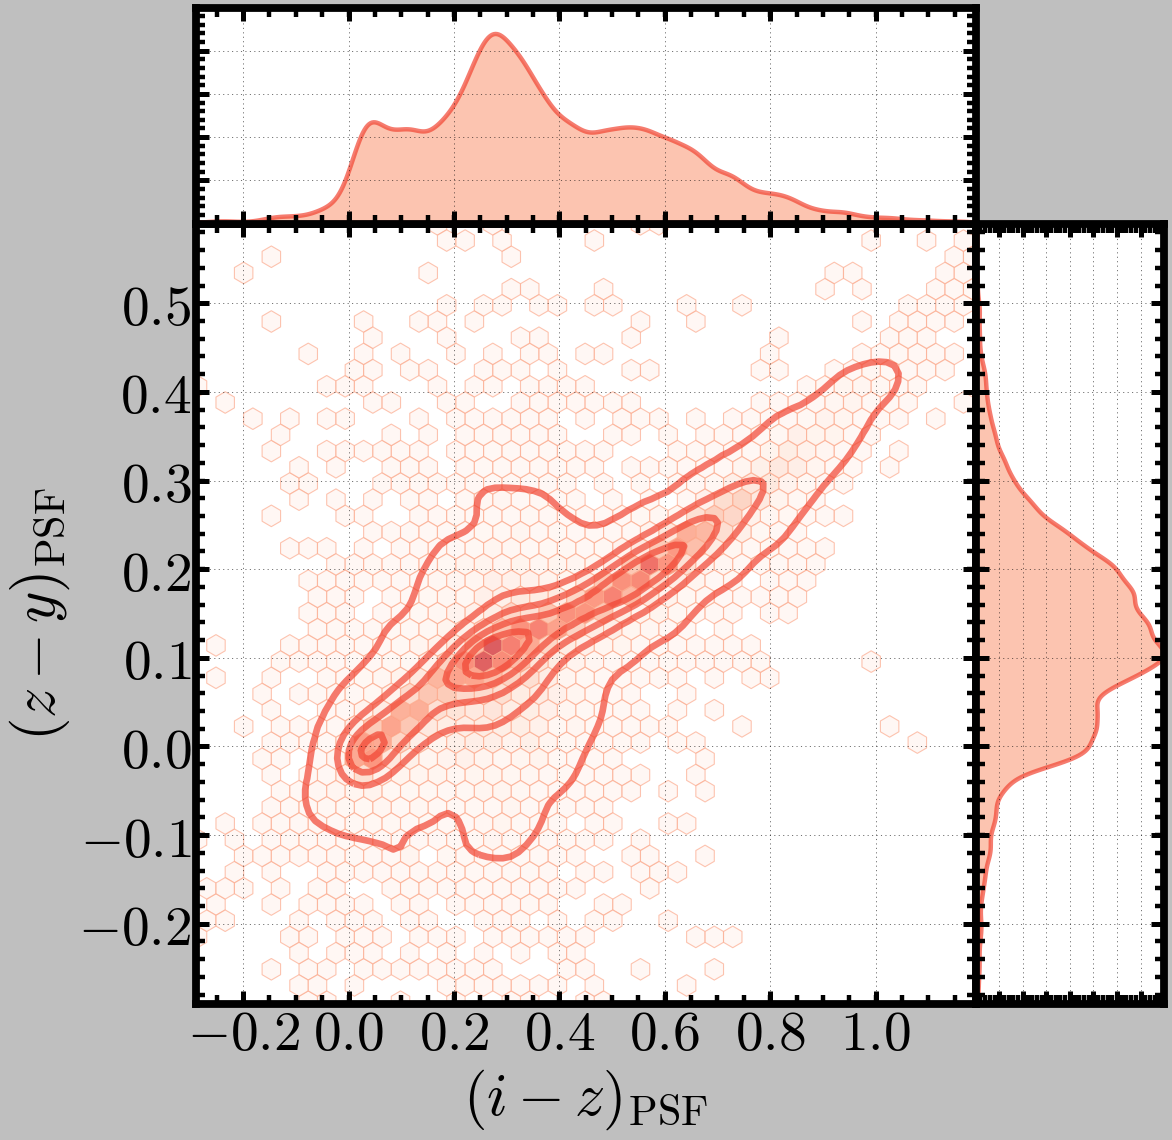

In [30]:
# --------------------------------------------------------------------------------------- #
## Prepare the data

xmin, xmax = -0.29, 1.19
ymin, ymax = -0.29, 0.59

xx = starData['imag_psf'] - starData['zmag_psf']
yy = starData['zmag_psf'] - starData['ymag_psf']
xTemp, yTemp = copy.deepcopy(xx), copy.deepcopy(yy)
xx = xx[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]
yy = yy[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]

xlabel = r'$(i-z)_{\mathrm{PSF}}} \mathrm{(mag)}$'
ylabel = r'$(z-y)_{\mathrm{PSF}}} \mathrm{(mag)}$'

xtickFormat, ytickFormat = r'$\mathbf{%5.1f}$', r'$\mathbf{%5.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(15, 15))
ax1 = plt.axes(EC1)
ax2 = plt.axes(EC2)
ax3 = plt.axes(EC3)

ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, border=7.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)
ax2 = songPlotSetup(ax2, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
ax3 = songPlotSetup(ax3, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax1
ax1.grid()

# HexBin
HB = ax1.hexbin(xx, yy, cmap=ICMAP, mincnt=1,
                alpha=0.7, gridsize=[42, 24], label=r'$\mathrm{Good\ Seeing}$',
                marginals=False, vmin=5, vmax=350, 
                edgecolor=ICMAP(0.3))

## Contour
H, xbins, ybins = np.histogram2d(xx, yy, bins=(100, 100))
H = gaussian_filter(H, 2)
levels = np.linspace(1, H.max(), 6)
Nx, Ny = len(xbins), len(ybins)
CS = ax1.contour(H.T, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], 
                 colors=(ICMAP(0.6), ICMAP(0.6)),
                 linewidths=6, levels=levels, alpha=0.7)

# --------------------------------------------------------------------------------------- #
ax1.set_xlabel(xlabel, size=54)
ax1.set_ylabel(ylabel, size=54)

## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
"""
l_handles, l_labels = ax1.get_legend_handles_labels()
l_handles[0] = mpatches.RegularPolygon((0,0), 6)
l_handles.append(CS.collections[-1])
l_labels[0] = '$\mathrm{Good\ Seeing}$'
l_labels.append('$\mathrm{Bad\ Seeing}$')
ax1.legend(l_handles, l_labels, loc=(0.52, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=40, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.3)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ICMAP(0.3))
legend.legendHandles[1].set_color(ICMAP(0.8))
"""
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2

ax2.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=ICMAP(0.3), edgecolor=ICMAP(0.6), 
         alpha=0.7, linewidth=4.0)

ax2.set_xlim(ax1.get_xlim())
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax3

ax3.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(yy[:, None])
yPlot = np.linspace(ymin, ymax, 500)
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor=ICMAP(0.3), edgecolor=ICMAP(0.6),
                  alpha=0.7, linewidth=4.0)

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

fig.savefig(os.path.join(figDir, 'cosmos_star_iz_zy_1.pdf'), 
            format='pdf', dpi=90)

# Extreme deconvolution modeling

In [6]:
gmag = starData['gmag_psf'].data
rmag = starData['rmag_psf'].data
imag = starData['imag_psf'].data
zmag = starData['zmag_psf'].data
ymag = starData['ymag_psf'].data

gerr = starData['gmag_psf_err'].data
rerr = starData['rmag_psf_err'].data
ierr = starData['imag_psf_err'].data
zerr = starData['zmag_psf_err'].data
yerr = starData['ymag_psf_err'].data

X = np.vstack([gmag, rmag, imag, zmag, ymag]).T

Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([gerr ** 2, 
                                 rerr ** 2,
                                 ierr ** 2,
                                 zerr ** 2, 
                                 yerr ** 2]).T

In [9]:
#------------------------------------------------------------
# compute and save results
@pickle_results("cosmos_star_xd_2.pkl")
def compute_XD_results(n_components=30, n_iter=300):
    clf = XDGMM(n_components, n_iter=n_iter)
    clf.fit(X, Xerr)
    return clf

clf = compute_XD_results()

@pickle_results: using precomputed results from 'cosmos_star_xd_2.pkl'


In [10]:
N = 300000
starSample = clf.sample(N)

gSample = starSample[:, 0]
rSample = starSample[:, 1]
iSample = starSample[:, 2]
zSample = starSample[:, 3]
ySample = starSample[:, 4]

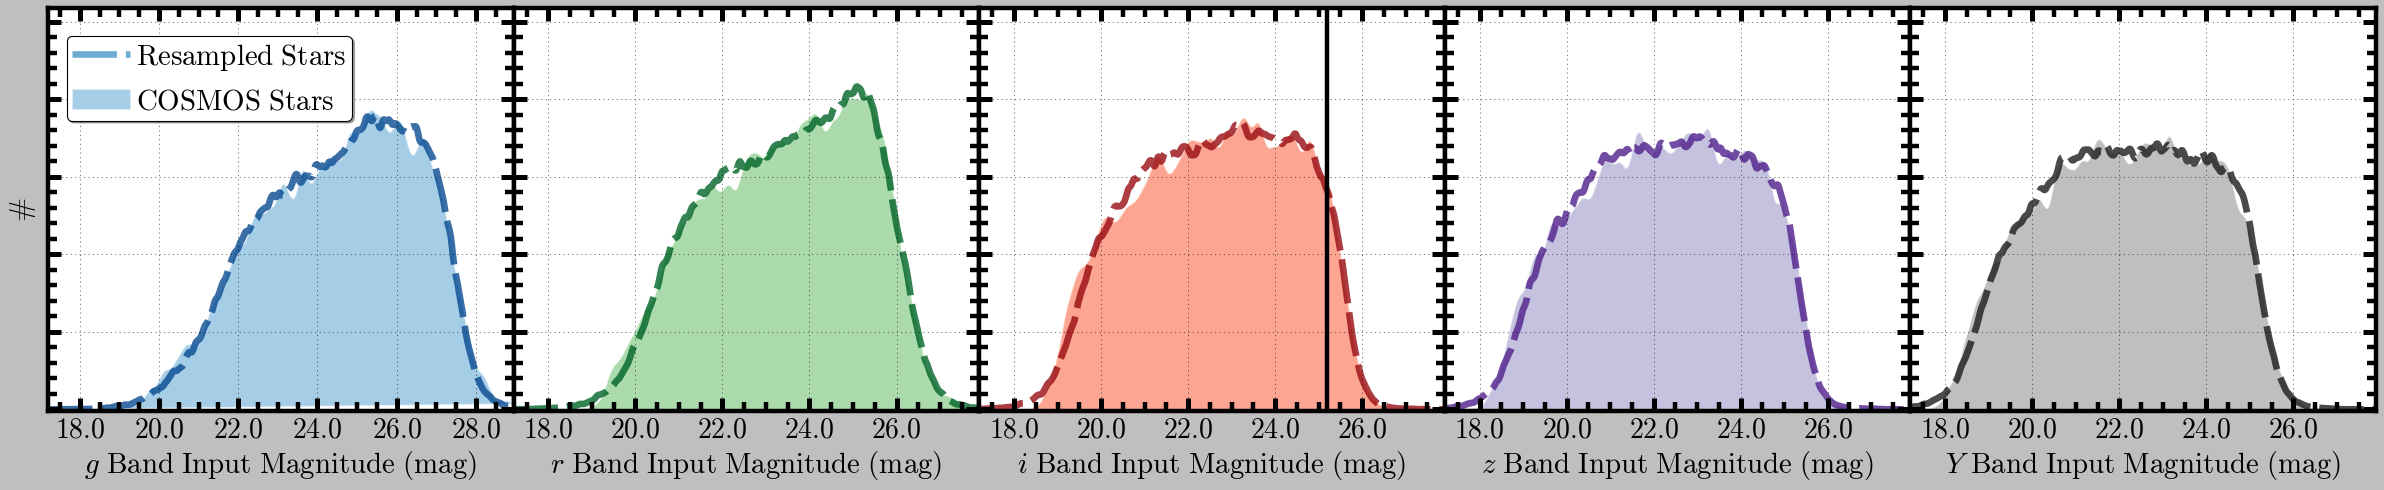

In [23]:
xtickFormat, ytickFormat = r'$\mathbf{%4.1f}$', r'$\mathbf{%4.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(30,6))
fig.subplots_adjust(left=0.02, right=0.99, bottom=0.15, top=0.99, 
                    hspace=0.0, wspace=0.0)

# --------------------------------------------------------------------------------------- #
## Ax1
ax1 = fig.add_subplot(151)
ax1.grid()
ax1 = songPlotSetup(ax1, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

## X, Y limits
xmin, xmax = 17.2, 28.95
ymin, ymax = -0.001, 0.259

xx2 = gSample
kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(xx2[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax1.plot(xPlot, np.exp(log_dens), color=GCMAP(0.9), alpha=0.8, linewidth=6.0, 
         linestyle='--', dashes=(40,8), label=r'$\mathrm{Resampled\ Stars}$')

xx = starData['gmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax1.fill(xPlot[:, None], np.exp(log_dens), facecolor=GCMAP(0.5), edgecolor=GCMAP(0.1), 
         alpha=0.6, linewidth=1.0, label=r'$\mathrm{COSMOS\ Stars}$', zorder=0)

ax1.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$g\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ylabel = r'$\#$'
ax1.set_xlabel(xlabel, size=26)
ax1.set_ylabel(ylabel, size=26)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.04, 0.72), shadow=True, fancybox=True, 
           numpoints=1, fontsize=26, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.2)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(GCMAP(0.6))
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2
ax2 = fig.add_subplot(152)
ax2.grid()
ax2 = songPlotSetup(ax2, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['rmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=RCMAP(0.5), edgecolor=RCMAP(0.1), 
         alpha=0.6, linewidth=1.0)

xx2 = rSample
kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(xx2[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.plot(xPlot, np.exp(log_dens), color=RCMAP(0.9), alpha=0.8, linewidth=6.0, 
         linestyle='--', dashes=(40,8))

ax2.set_ylim(ax1.get_ylim())
ax2.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$r\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax2.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax2.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax3
ax3 = fig.add_subplot(153)
ax3.grid()
ax3 = songPlotSetup(ax3, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['imag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax3.fill(xPlot[:, None], np.exp(log_dens), facecolor=ICMAP(0.5), edgecolor=ICMAP(0.1), 
         alpha=0.6, linewidth=1.0)

xx2 = iSample
kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(xx2[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax3.plot(xPlot, np.exp(log_dens), color=ICMAP(0.9), alpha=0.8, linewidth=6.0, 
         linestyle='--', dashes=(40,8))

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())

ax3.axvline(25.2, linewidth=4.0, c='k')

xlabel = r'$i\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax3.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax3.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax4
ax4 = fig.add_subplot(154)
ax4.grid()
ax4 = songPlotSetup(ax4, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['zmag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax4.fill(xPlot[:, None], np.exp(log_dens), facecolor=ZCMAP(0.5), edgecolor=ZCMAP(0.1), 
         alpha=0.6, linewidth=1.0)

xx2 = zSample
kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(xx2[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax4.plot(xPlot, np.exp(log_dens), color=ZCMAP(0.9), alpha=0.8, linewidth=6.0, 
         linestyle='--', dashes=(40,8))

ax4.set_ylim(ax1.get_ylim())
ax4.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$z\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax4.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax4.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
## Ax5
ax5 = fig.add_subplot(155)
ax5.grid()
ax5 = songPlotSetup(ax5, ylabel=25, xlabel=25, border=4.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)

# Good seeing
xx = starData['ymag_psf']
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax5.fill(xPlot[:, None], np.exp(log_dens), facecolor=YCMAP(0.5), edgecolor=YCMAP(0.1), 
         alpha=0.6, linewidth=1.0)

xx2 = ySample
kde = KernelDensity(kernel='gaussian', bandwidth=0.04).fit(xx2[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax5.plot(xPlot, np.exp(log_dens), color=YCMAP(0.9), alpha=0.8, linewidth=6.0, 
         linestyle='--', dashes=(40,8))

ax5.set_ylim(ax1.get_ylim())
ax5.yaxis.set_major_formatter(NullFormatter())

xlabel = r'$Y\ \mathrm{Band\ Input\ Magnitude\ (mag)}$'
ax5.set_xlabel(xlabel, size=26)

## X, Y limits
xmin, xmax = 17.2, 27.9
ax5.set_xlim(xmin, xmax)

# --------------------------------------------------------------------------------------- #
plt.show()

fig.savefig(os.path.join(figDir, 'cosmos_star_hist_2.pdf'), 
            format='pdf', dpi=90)

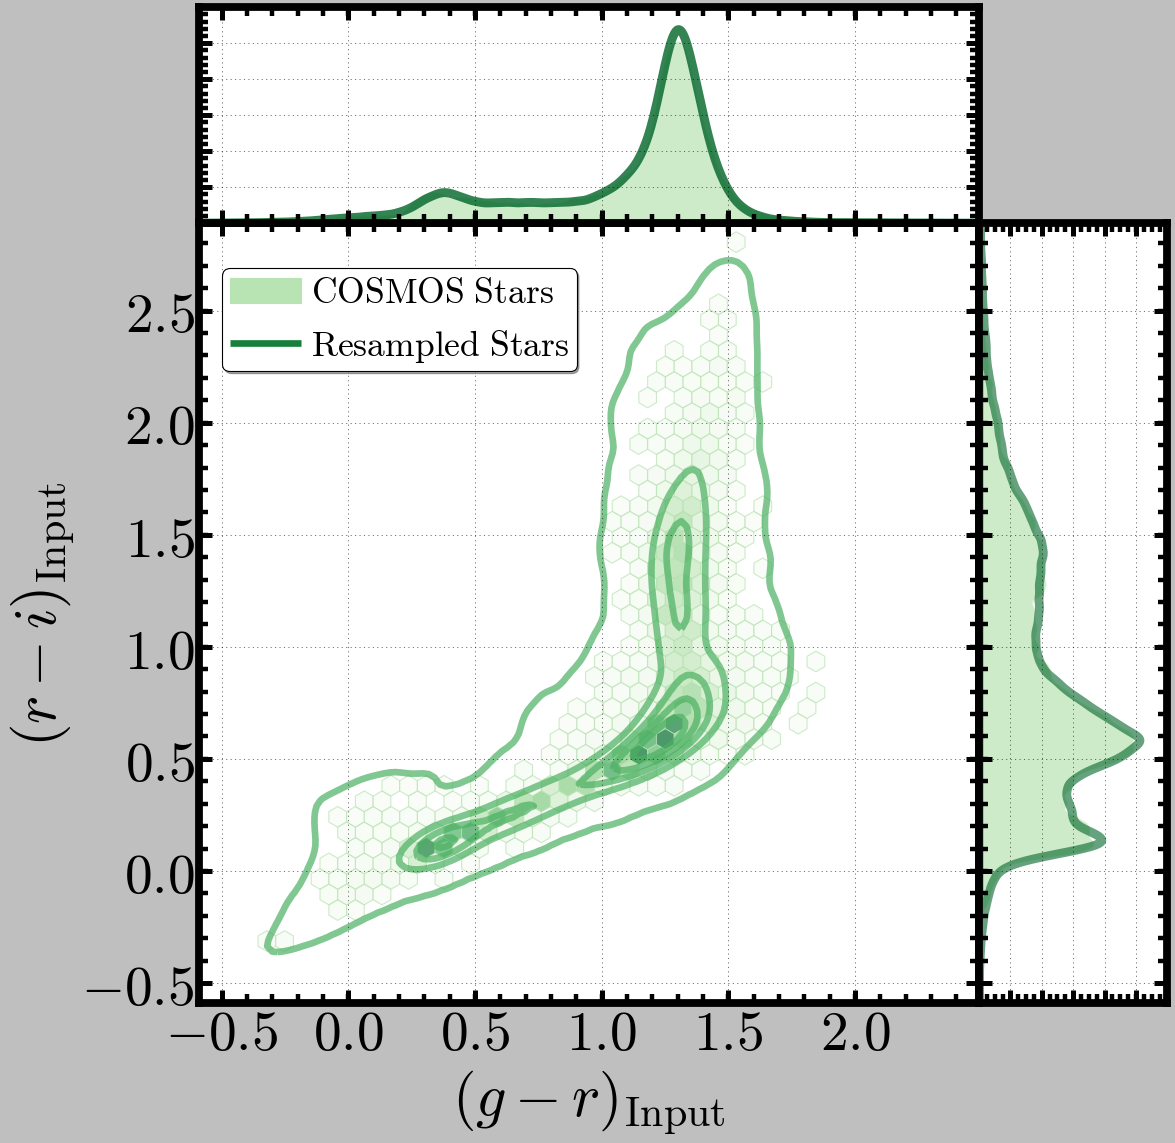

In [22]:
# --------------------------------------------------------------------------------------- #
## Prepare the data

xmin, xmax = -0.59, 2.49
ymin, ymax = -0.59, 2.89

xx = starData['gmag_psf'] - starData['rmag_psf']
yy = starData['rmag_psf'] - starData['imag_psf']
xTemp, yTemp = copy.deepcopy(xx), copy.deepcopy(yy)
xx = xx[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]
yy = yy[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]

xx1 = gSample - rSample
yy1 = rSample - iSample
xTemp, yTemp = copy.deepcopy(xx1), copy.deepcopy(yy1)
xx1 = xx1[(xTemp >= xmin) & (xTemp <= xmax) &
          (yTemp >= ymin) & (yTemp <= ymax)]
yy1 = yy1[(xTemp >= xmin) & (xTemp <= xmax) &
          (yTemp >= ymin) & (yTemp <= ymax)]

xlabel = r'$(g-r)_{\mathrm{Input}}} \mathrm{(mag)}$'
ylabel = r'$(r-i)_{\mathrm{Input}}} \mathrm{(mag)}$'

xtickFormat, ytickFormat = r'$\mathbf{%5.1f}$', r'$\mathbf{%5.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(15, 15))
ax1 = plt.axes(EC1)
ax2 = plt.axes(EC2)
ax3 = plt.axes(EC3)

ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, border=7.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)
ax2 = songPlotSetup(ax2, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
ax3 = songPlotSetup(ax3, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax1
ax1.grid()

# HexBin
HB = ax1.hexbin(xx, yy, cmap=RCMAP, mincnt=5,
                alpha=0.7, gridsize=[42, 24], label=r'$\mathrm{COSMOS\ Stars}$',
                marginals=False, vmin=5, vmax=350, 
                edgecolor=RCMAP(0.3))

## Contour
H, xbins, ybins = np.histogram2d(xx1, yy1, bins=(140, 140))
H = gaussian_filter(H, 2)
levels = np.linspace(5, H.max(), 6)
Nx, Ny = len(xbins), len(ybins)
CS = ax1.contour(H.T, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], 
                 colors=(RCMAP(0.6), RCMAP(0.6)),
                 linewidths=6, levels=levels, alpha=0.7, label=r'$\mathrm{Resampled\ Stars}$')

# --------------------------------------------------------------------------------------- #
ax1.set_xlabel(xlabel, size=54)
ax1.set_ylabel(ylabel, size=54)

## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
l_handles[0] = mpatches.RegularPolygon((0,0), 6)
l_handles.append(CS.collections[-1])
l_labels[0] = '$\mathrm{COSMOS\ Stars}$'
l_labels.append('$\mathrm{Resampled\ Stars}$')
ax1.legend(l_handles, l_labels, loc=(0.03, 0.81), shadow=True, fancybox=True, 
           numpoints=1, fontsize=32, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.3)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(RCMAP(0.3))
legend.legendHandles[1].set_color(RCMAP(0.8))
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2

ax2.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=RCMAP(0.3), edgecolor=RCMAP(0.1), 
         alpha=0.7, linewidth=1.0)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(xx1[:, None])
log_dens = kde.score_samples(xPlot[:, None])
ax2.plot(xPlot, np.exp(log_dens), color=RCMAP(0.9), alpha=0.8, linewidth=8.0, 
         linestyle='-')

ax2.set_xlim(ax1.get_xlim())
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax3

ax3.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(yy[:, None])
yPlot = np.linspace(ymin, ymax, 500)
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor=RCMAP(0.3), edgecolor=RCMAP(0.1),
                  alpha=0.7, linewidth=1.0)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(yy1[:, None])
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor='None', edgecolor=RCMAP(0.9),
                  alpha=0.6, linewidth=8.0, linestyle='-')

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

plt.show()
fig.savefig(os.path.join(figDir, 'cosmos_star_gr_ri_2.pdf'), 
            format='pdf', dpi=90)

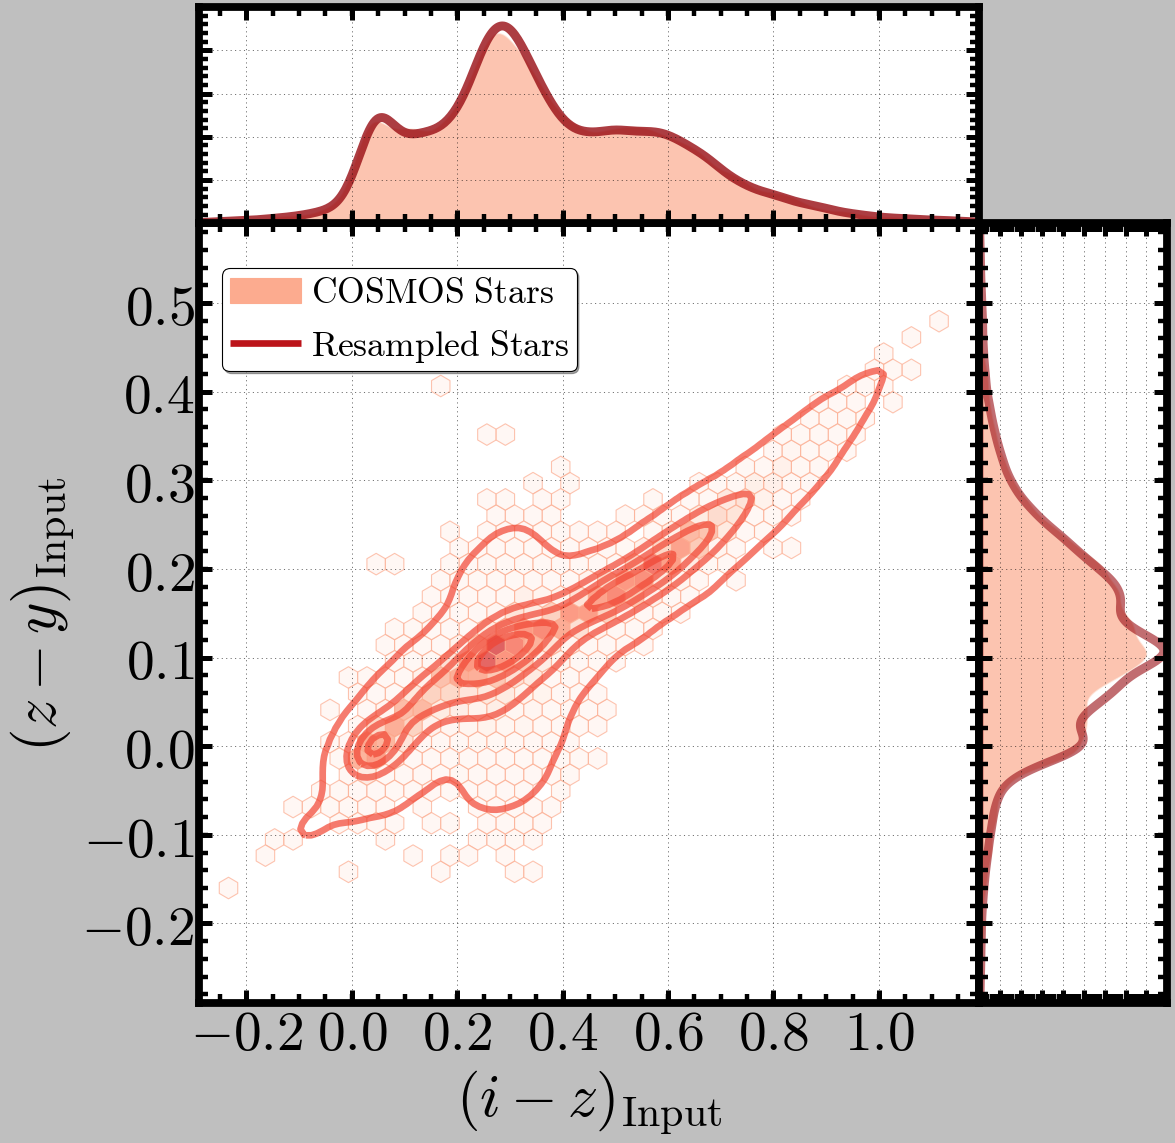

In [21]:
# --------------------------------------------------------------------------------------- #
## Prepare the data

xmin, xmax = -0.29, 1.19
ymin, ymax = -0.29, 0.59

xx = starData['imag_psf'] - starData['zmag_psf']
yy = starData['zmag_psf'] - starData['ymag_psf']
xTemp, yTemp = copy.deepcopy(xx), copy.deepcopy(yy)
xx = xx[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]
yy = yy[(xTemp >= xmin) & (xTemp <= xmax) &
        (yTemp >= ymin) & (yTemp <= ymax)]

xx1 = iSample - zSample
yy1 = zSample - ySample
xTemp, yTemp = copy.deepcopy(xx1), copy.deepcopy(yy1)
xx1 = xx1[(xTemp >= xmin) & (xTemp <= xmax) &
          (yTemp >= ymin) & (yTemp <= ymax)]
yy1 = yy1[(xTemp >= xmin) & (xTemp <= xmax) &
          (yTemp >= ymin) & (yTemp <= ymax)]

xlabel = r'$(i-z)_{\mathrm{Input}}} \mathrm{(mag)}$'
ylabel = r'$(z-y)_{\mathrm{Input}}} \mathrm{(mag)}$'

xtickFormat, ytickFormat = r'$\mathbf{%5.1f}$', r'$\mathbf{%5.1f}\ $'
ytickFormat2 = r'$\mathbf{%3.1f}$'

# --------------------------------------------------------------------------------------- #
## Setup up figure
fig = plt.figure(figsize=(15, 15))
ax1 = plt.axes(EC1)
ax2 = plt.axes(EC2)
ax3 = plt.axes(EC3)

ax1 = songPlotSetup(ax1, ylabel=50, xlabel=50, border=7.0,
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat)
ax2 = songPlotSetup(ax2, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
ax3 = songPlotSetup(ax3, ylabel=50, xlabel=50, border=7.0, 
                    xtickFormat=xtickFormat, ytickFormat=ytickFormat2)
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax1
ax1.grid()

# HexBin
HB = ax1.hexbin(xx, yy, cmap=ICMAP, mincnt=5,
                alpha=0.7, gridsize=[42, 24], label=r'$\mathrm{Good\ Seeing}$',
                marginals=False, vmin=30, vmax=350, 
                edgecolor=ICMAP(0.3))

## Contour
H, xbins, ybins = np.histogram2d(xx1, yy1, bins=(140, 140))
H = gaussian_filter(H, 2)
levels = np.linspace(15, H.max(), 6)
Nx, Ny = len(xbins), len(ybins)
CS = ax1.contour(H.T, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], 
                 colors=(ICMAP(0.6), ICMAP(0.6)),
                 linewidths=6, levels=levels, alpha=0.7)

# --------------------------------------------------------------------------------------- #
ax1.set_xlabel(xlabel, size=54)
ax1.set_ylabel(ylabel, size=54)

## X, Y limits
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)

# --------------------------------------------------------------------------------------- #
## Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
l_handles[0] = mpatches.RegularPolygon((0,0), 6)
l_handles.append(CS.collections[-1])
l_labels[0] = '$\mathrm{COSMOS\ Stars}$'
l_labels.append('$\mathrm{Resampled\ Stars}$')
ax1.legend(l_handles, l_labels, loc=(0.03, 0.81), shadow=True, fancybox=True, 
           numpoints=1, fontsize=32, scatterpoints=1, 
           markerscale=1.2, borderpad=0.2, handletextpad=0.3)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ICMAP(0.3))
legend.legendHandles[1].set_color(ICMAP(0.8))
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax2

ax2.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(xx[:, None])
xPlot = np.linspace(xmin, xmax, 500)
log_dens = kde.score_samples(xPlot[:, None])
ax2.fill(xPlot[:, None], np.exp(log_dens), facecolor=ICMAP(0.3), edgecolor=ICMAP(0.1), 
         alpha=0.7, linewidth=1.0)

kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(xx1[:, None])
log_dens = kde.score_samples(xPlot[:, None])
ax2.plot(xPlot, np.exp(log_dens), color=ICMAP(0.9), alpha=0.8, linewidth=8.0, 
         linestyle='-')

ax2.set_xlim(ax1.get_xlim())
ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

# --------------------------------------------------------------------------------------- #
## Ax3

ax3.grid()
# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(yy[:, None])
yPlot = np.linspace(ymin, ymax, 500)
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor=ICMAP(0.3), edgecolor=ICMAP(0.1),
                  alpha=0.7, linewidth=1.0)

kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(yy1[:, None])
log_dens = kde.score_samples(yPlot[:, None])
ax3.fill_betweenx(yPlot, 0.0, np.exp(log_dens), facecolor='None', edgecolor=ICMAP(0.9),
                  alpha=0.6, linewidth=8.0, linestyle='-')

ax3.set_ylim(ax1.get_ylim())
ax3.yaxis.set_major_formatter(NullFormatter())
ax3.xaxis.set_major_formatter(NullFormatter())
# --------------------------------------------------------------------------------------- #

plt.show()
fig.savefig(os.path.join(figDir, 'cosmos_star_iz_zy_2.pdf'), 
            format='pdf', dpi=90)